# <span style="color:red">Part 0 : Installing Packages</span>

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import math as mt
import statsmodels.api as sm
import numpy as np

***

# <span style="color:red">Part A : Analysis of Climate Change Disasters</span>

- ### A.0 : Data Preparation

In [4]:
#Get the data from EM_DAT
disasters_data = pd.read_excel("disasters_data.xlsx")

#Countries and Disasters to be analyzed
countries = ["Bhutan", "India", "Nepal", "Pakistan", "Sri Lanka", "Afghanistan", "Bangladesh"]
disasters = ["Storm", "Flood", "Extreme temperature", "Drought", "Wildfire"]

# Filter the Disasters data
disasters_data = disasters_data[(disasters_data["Country"].isin(countries)) & (disasters_data["Disaster Type"].isin(disasters))]
disasters_data.drop(columns=["DisNo.", "Historic", ],inplace=True)
disasters_data.drop(disasters_data.iloc[:,[0,1,4,5,6,7,9,10,11,12,13,14,15,16,20,21,22,-1,-2,-3,-4]],inplace=True, axis=1)

# DATA FRAME 1 : TIME SERIES OF DISASTER FOR EACH COUNTRY
dis_country = pd.DataFrame(index=range(1980,2023),columns=countries)
for country in countries:
    for x in range(1980,2023):
        dis_country.loc[x, country] = sum((disasters_data["Start Year"]== x ) & (disasters_data["Country"] == country))

### DATA FRAME 2 : TIME SERIES OF DISASTER FOR EACH TYPE
dis_type = pd.DataFrame(index = range(1980,2023)) # dis contains the number of disasters (by type) for every year

for x in range(1980,2023):
    dis_type.loc[x, "# Overall Disasters"] = sum(disasters_data["Start Year"] == x)
    for type in disasters:
        dis_type.loc[x, f"# Overall {type}"] = sum((disasters_data["Start Year"] == x) & (disasters_data["Disaster Type"] == type))

### DATA FRAME 3 : TOTAL NUMBER OF DISASTER (FROM 1980 TO 2022) FOR EACH TYPE AND COUNTRY
dis_type_country = pd.DataFrame(index=["Bhutan", "India", "Nepal", "Pakistan", "Sri Lanka", "Afghanistan", "Bangladesh", "Total x Type"], 
                    columns= ["Storm", "Flood", "Extreme temperature", "Drought", "Wildfire", "Total x Country"])

for country in countries:
    dis_type_country.loc[country, "Total x Country"] = sum(disasters_data["Country"] == country)
    for disaster in disasters:
        dis_type_country.loc[country, disaster] = sum( (disasters_data["Country"] == country) & (disasters_data["Disaster Type"] == disaster))

for j in range(0,7):
    for i in range(0,5):
        dis_type_country.iloc[7, i] = sum(dis_type_country.iloc[0:7,i])

### FUNCTION TO CREATE A DATA SET FOR A SPECIFIC COUNTRY OF THE TIME SERIES OF DISASTERS (DIVIDED BY TYPE)
def create_disaster_dataframe(country, disasters, data):
    dis_country_type = pd.DataFrame(columns=disasters, index=range(1980, 2023))
    for year in range(1980, 2023):
        for disaster in disasters:
            dis_country_type.loc[year, disaster] = sum((data["Start Year"] == year) & 
                                                       (data["Country"] == country) & 
                                                       (data["Disaster Type"] == disaster))
    return dis_country_type

<br>

- ### A.1 : Stackplot of Disasters (divided by type) frequency

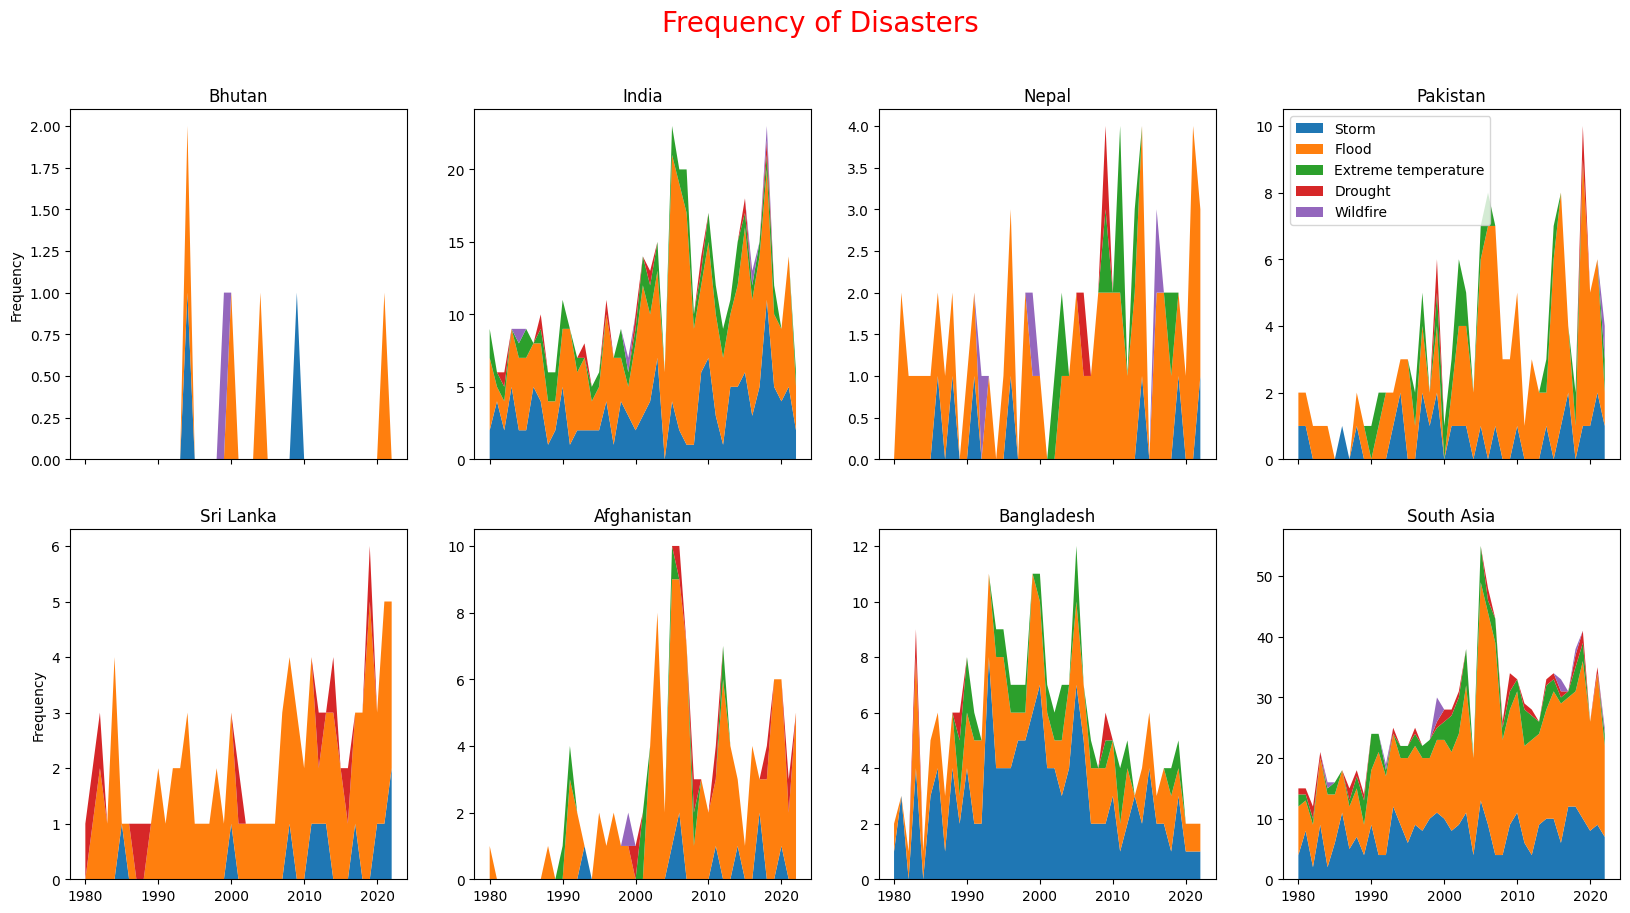

In [6]:
fig1, axs = plt.subplots(ncols=4, nrows=2, sharex=True, figsize=(20,10))
axs = axs.flatten()
for i, country in enumerate(countries):
    stackplot_disaster_dataframe = create_disaster_dataframe(country=country , disasters=disasters, data=disasters_data).astype(int)
    axs[i].stackplot(range(1980,2023), stackplot_disaster_dataframe["Storm"],
                                stackplot_disaster_dataframe["Flood"],
                                stackplot_disaster_dataframe["Extreme temperature"],
                                stackplot_disaster_dataframe["Drought"],
                                stackplot_disaster_dataframe["Wildfire"])
    axs[i].set_title(f"{country}")

axs[7].stackplot(range(1980,2023), dis_type["# Overall Storm"],
                                dis_type["# Overall Flood"],
                                dis_type["# Overall Extreme temperature"],
                                dis_type["# Overall Drought"],
                                dis_type["# Overall Wildfire"])
axs[7].set_title("South Asia")
axs[0].set_ylabel("Frequency")
axs[4].set_ylabel("Frequency")
axs[3].legend(["Storm","Flood","Extreme temperature","Drought","Wildfire"], loc="upper left")
fig1.suptitle("Frequency of Disasters",color="red",fontsize=20 )
plt.show()

<br>

- ### A.2 : Pie plots of disasters 

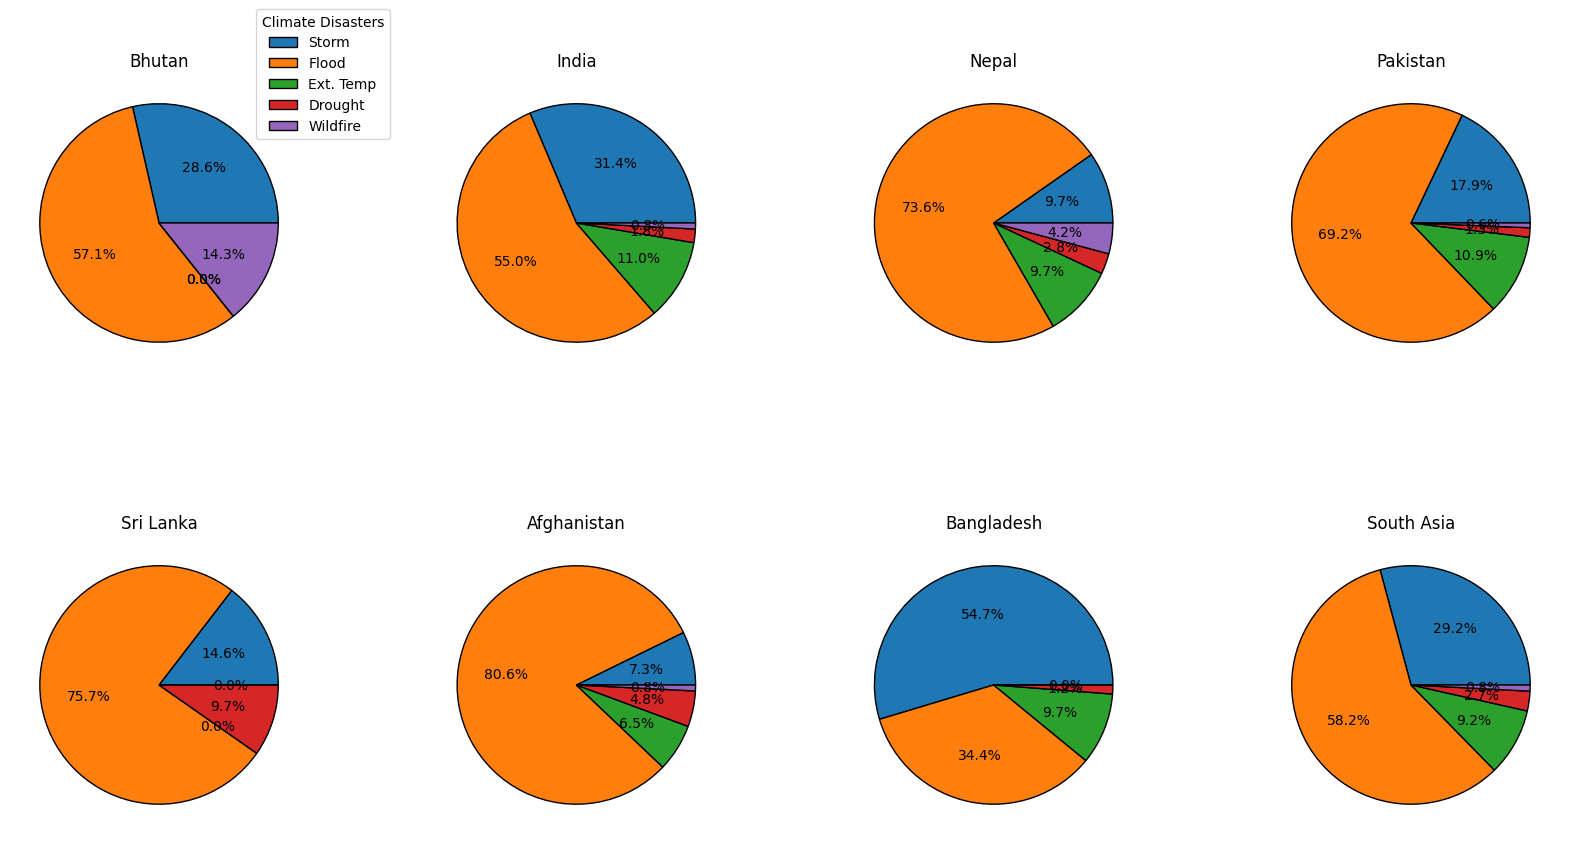

In [7]:
### PLOT 2 : PIE PLOTS OF DISASTERS BY COUNTRY AND TYPE
fig3, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i, country in enumerate(countries):

    pie = axs[i].pie(dis_type_country.loc[country].iloc[0:5], autopct="%1.1f%%", wedgeprops={"edgecolor":"black"})
    axs[i].set_title(country)
    if i == 0:  # For the first subplot, create a legend
        axs[i].legend(pie[0], ["Storm", "Flood", "Ext. Temp", "Drought", "Wildfire"], title="Climate Disasters", loc="center", bbox_to_anchor=(1.05, 1))

total_pie = plt.pie(dis_type_country.iloc[7,0:5], autopct="%1.1f%%", wedgeprops={"edgecolor":"black"})
plt.title("South Asia")
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

In [8]:
dis_type_country

,Storm,Flood,Extreme temperature,Drought,Wildfire,Total x Country
Bhutan,2,4,0,0,1,7
India,154,270,54,9,4,491
Nepal,7,53,7,2,3,72
Pakistan,28,108,17,2,1,156
Sri Lanka,15,78,0,10,0,103
Afghanistan,9,100,8,6,1,124
Bangladesh,135,85,24,3,0,247
Total x Type,350,698,110,32,10,NaN


****

<br>

# <span style="color:red">PART B : Analysis of Climate Change Measures</span> 

- ### B.0 : Data Preparation

In [9]:
temp_delta = pd.read_excel("Temperature_Change.xlsx", header=0, index_col=0)
sample = ["World", "Bhutan", "India", "Nepal", "Pakistan", "Sri Lanka", "Afghanistan", "Bangladesh"]

### DATA FRAME 1 ; temperature changes with respect to a baseline climatology 
Temp_Delta = pd.DataFrame(index=sample, columns=range(1961,2024))
Temp_Delta = Temp_Delta.apply(pd.to_numeric, errors='coerce')

for x in sample:
    Temp_Delta.loc[x,:] = temp_delta.loc[x,:]

# POSSIBLE BREAKs FROM VISUAL ISPECTION (** significance at 0.01 | * significance at 0.05)
breaks = {"World" : 1986,      # **
          "Bhutan": 1996,      # **
          "India" : 1998,      # *
          "Nepal" : 1998,      # 
          "Pakistan": 1998,    # **
          "Sri Lanka": 1978,   # *
          "Afghanistan": 1998, #
          "Bangladesh": 1994   # **
          }

### DATA FRAME 3; CHOW TEST STATISTICS
chow_statistics = pd.DataFrame(index=sample, columns=["Breaks","Chow Statistics", "Significance"])

for country in sample:
    Y = Temp_Delta.loc[country]
    Y1 = Temp_Delta.loc[country, :breaks[country]]
    Y2 = Temp_Delta.loc[country, breaks[country]:]
    X = sm.add_constant(Y.index)
    X1 = sm.add_constant(Y1.index)
    X2 = sm.add_constant(Y2.index)

    mod_all = sm.OLS(Y,X).fit() 
    ssr_all = mod_all.ssr

    mod_before_break = sm.OLS(Y1,X1).fit()
    ssr_before = mod_before_break.ssr

    mod_after_break = sm.OLS(Y2,X2).fit()
    ssr_after = mod_after_break.ssr

    numerator = (ssr_all - (ssr_before + ssr_after))/2
    denominator = (ssr_before + ssr_after)/(mod_all.nobs - 4)
    
    chow_test= numerator/denominator

    chow_statistics.loc[country, "Breaks"] = breaks[country]
    chow_statistics.loc[country, "Chow Statistics"] = chow_test # critical value at .99 is 4.98 and at .95 is 3.15
    
    if chow_statistics.loc[country, "Chow Statistics"] > 4.98:
        chow_statistics.loc[country, "Significance"] = "**"
    elif chow_statistics.loc[country, "Chow Statistics"] < 4.98 and chow_statistics.loc[country, "Chow Statistics"] > 3.15:
        chow_statistics.loc[country, "Significance"] = "*"
    else:
        chow_statistics.loc[country, "Significance"] = "-"

### REGRESSION OF COUNTRY (Y) VS WORLD (X) + DATA FRAME WITH RESIDUALS OF THE REGRESSION
Residuals = pd.DataFrame(columns=Temp_Delta.columns, index=sample[1:])
Coefficients = pd.DataFrame(columns=["α", "Pα >|T|", "β", "Pβ >|T|"], index=sample[1:])

for country in Residuals.index:
    mod = sm.OLS(Temp_Delta.loc[country, :], sm.add_constant(Temp_Delta.loc["World", :])).fit()
    predictedValues = mod.predict()
    res = Temp_Delta.loc[country, :] - predictedValues
    Residuals.loc[country] = res

    Coefficients.loc[country, "α"] = mod.params.iloc[0]
    Coefficients.loc[country, "Pα >|T|"] = mod.pvalues.iloc[0]
    Coefficients.loc[country, "β"] = mod.params.iloc[1]
    Coefficients.loc[country, "Pβ >|T|"] = mod.pvalues.iloc[1]

<br>

- ### B.1 : Temperature Change with respect to a baseline Climatology (1951-1980)

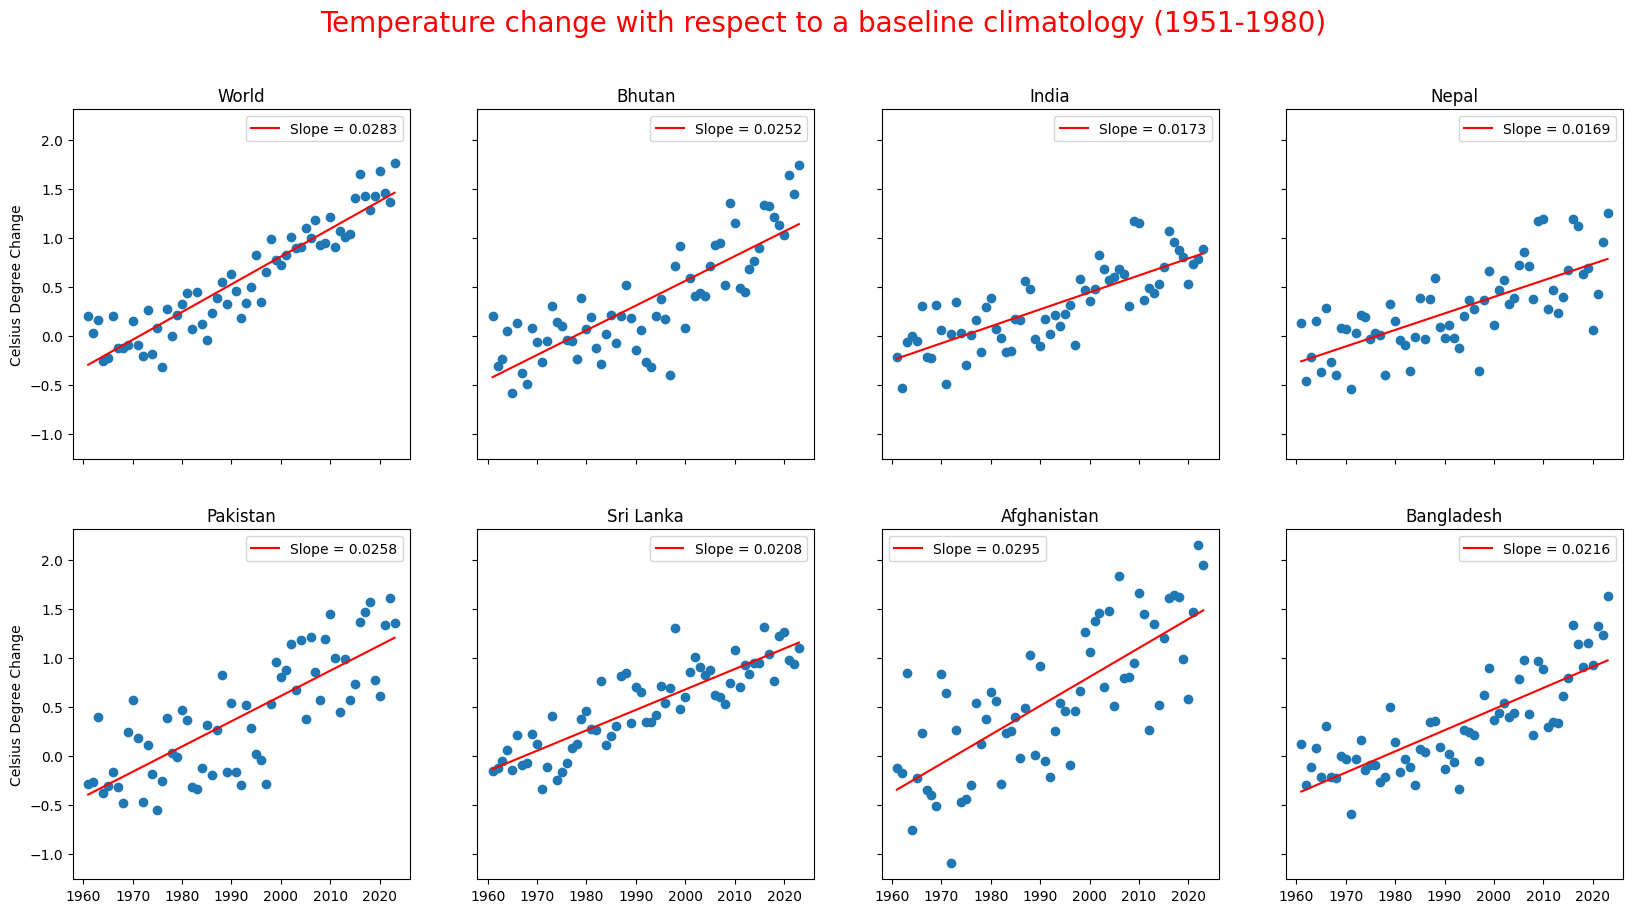

In [10]:
### FIG 1 ; SCATTER PLOT + REGRESSION OF TEMPERATURE CHANGE'S (Y) vs YEAR (X)
fig1, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,10))
axs = axs.flatten()
for i,country in enumerate(sample):
    axs[i].scatter(Temp_Delta.columns, Temp_Delta.loc[country])
    axs[i].set_title(country)

    m, b = np.polyfit(Temp_Delta.columns.astype(int), Temp_Delta.loc[country].astype(float),1)    #obtain m (slope) and b(intercept) of linear regression line
    axs[i].plot(np.asarray(Temp_Delta.columns), m*np.asarray(Temp_Delta.columns)+b, color="red", label=f"Slope = {m.round(decimals=4) }")     #add linear regression line to scatterplot 
    axs[i].legend()

axs[0].set_ylabel("Celsius Degree Change")
axs[4].set_ylabel("Celsius Degree Change")
fig1.suptitle("Temperature change with respect to a baseline climatology (1951-1980)",fontsize=20, color="r")
plt.show()

<br>

- ### B.2 : Temperature Change and Structural Breaks

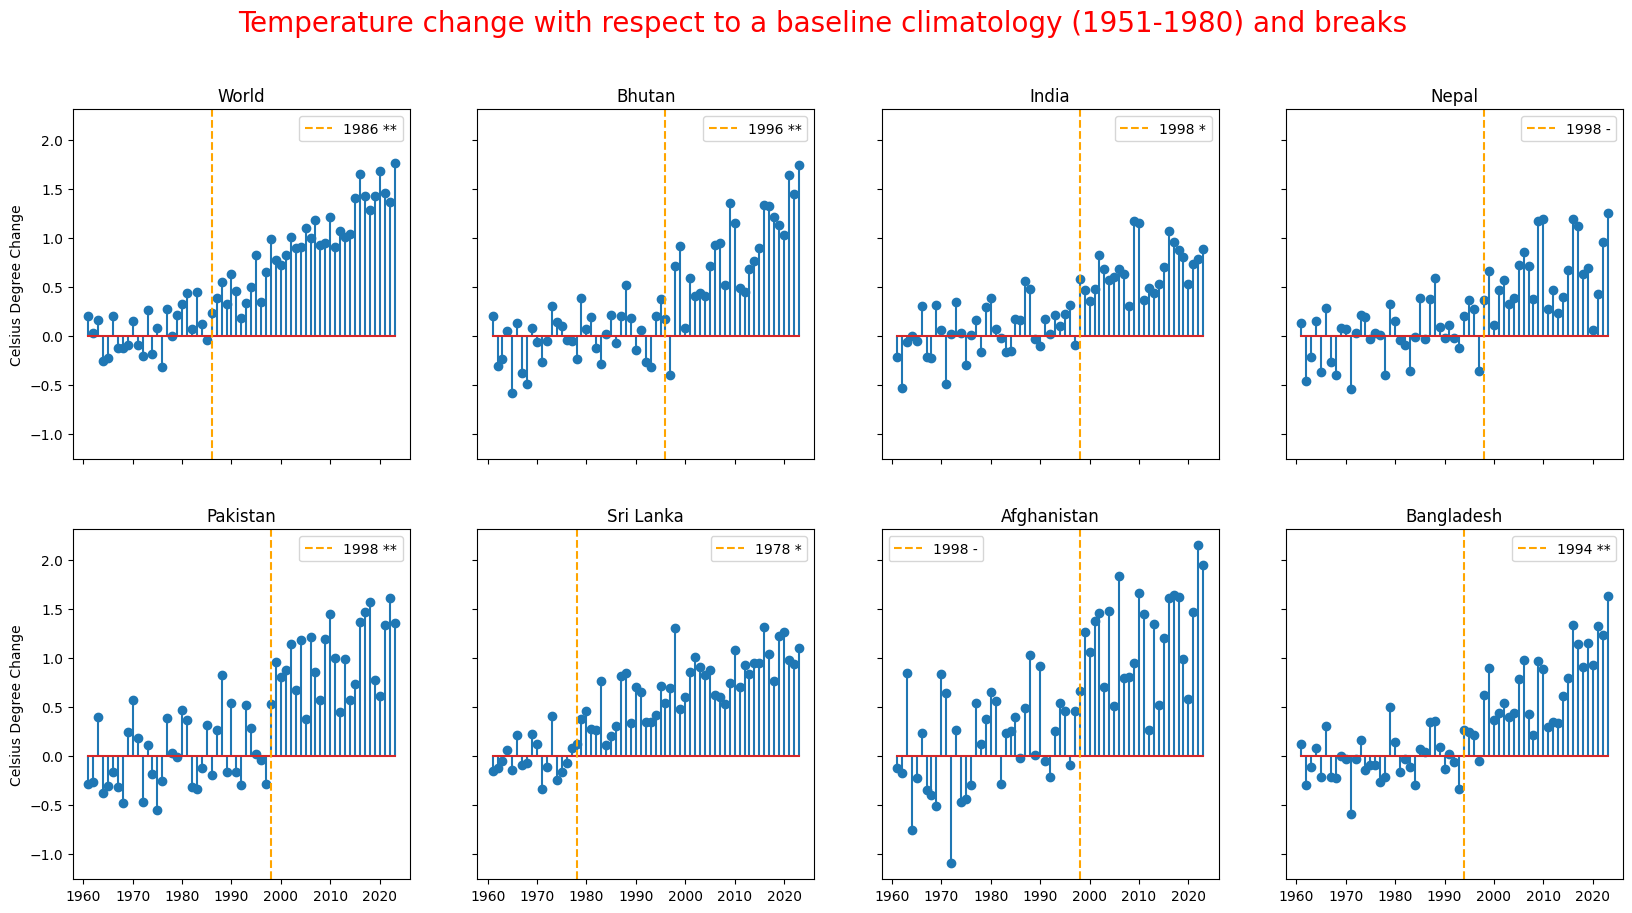

In [11]:
### FIG 2 ; STEM PLOT OF TEMPERATURE CHANGES + BREAK LINES 
fig2, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,10))
axs = axs.flatten()

for i,country in enumerate(sample):
    axs[i].stem(Temp_Delta.columns, Temp_Delta.loc[country])
    axs[i].set_title(country)
    axs[i].axvline(x=breaks[country], linestyle="--", color="orange", label=f"{breaks[country]} {chow_statistics.loc[country, "Significance"]}")
    axs[i].legend()
axs[0].set_ylabel("Celsius Degree Change")
axs[4].set_ylabel("Celsius Degree Change")
fig2.suptitle("Temperature change with respect to a baseline climatology (1951-1980) and breaks",fontsize=20, color="r")
plt.show()

<br>

In [12]:
chow_statistics

,Breaks,Chow Statistics,Significance
World,1986,9.423144,**
Bhutan,1996,12.189868,**
India,1998,3.222415,*
Nepal,1998,2.550284,-
Pakistan,1998,7.169058,**
Sri Lanka,1978,3.323815,*
Afghanistan,1998,2.779665,-
Bangladesh,1994,10.133455,**


<br>

- ### B.3) Regression of Country vs World Temperature Change

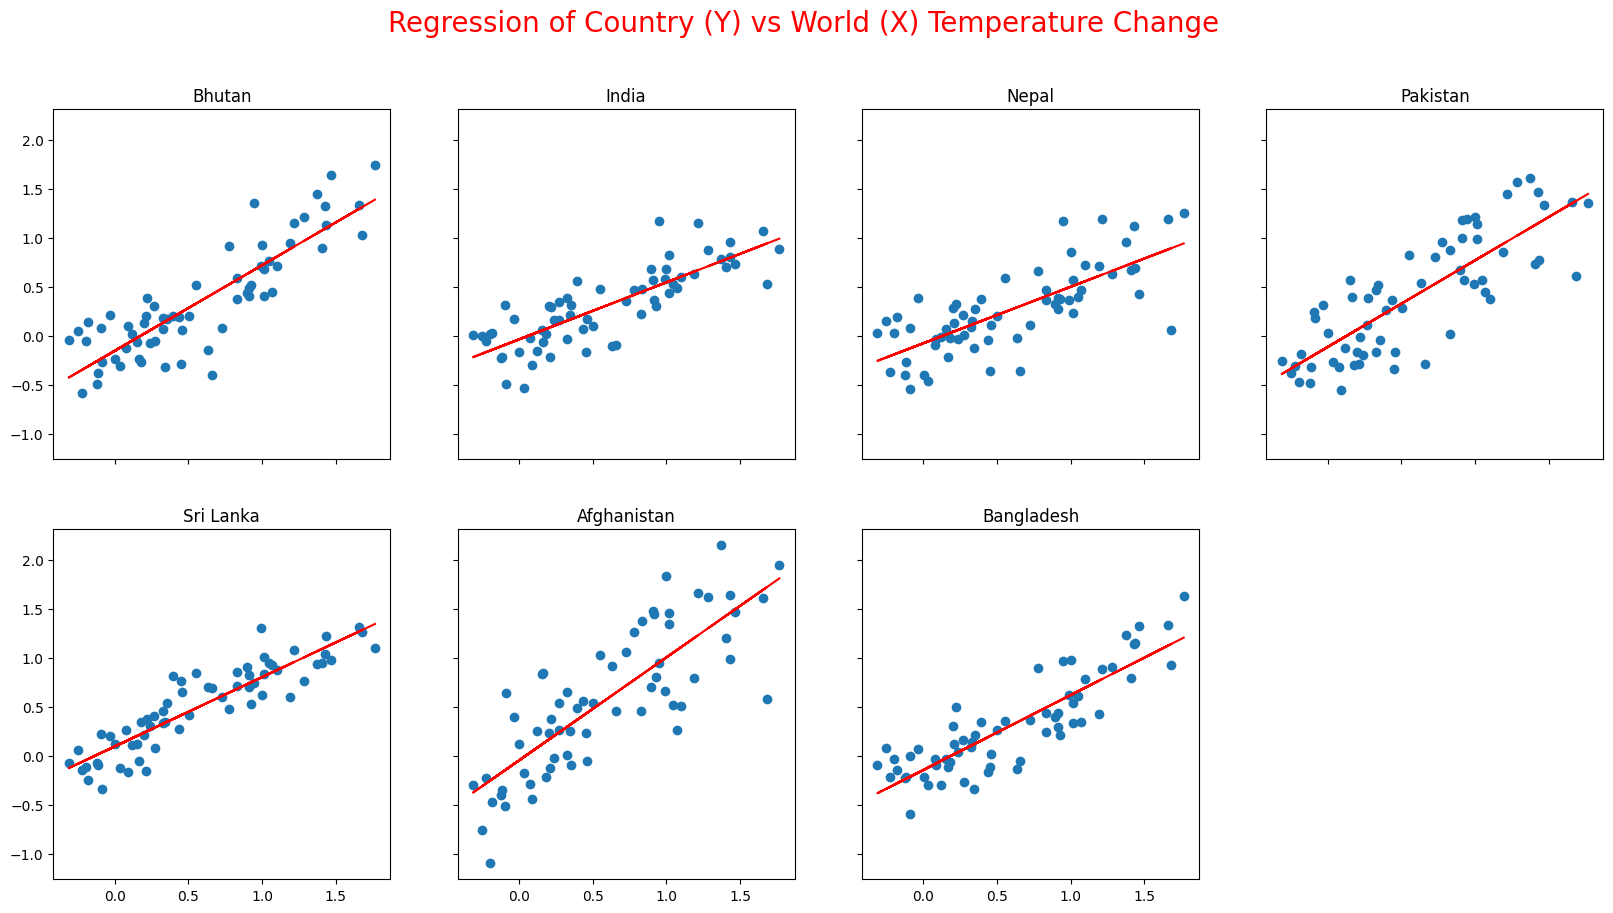

In [14]:
fig3, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(20,10))
axs = axs.flatten()

for i,country in enumerate(sample[1:]):
    axs[i].scatter(Temp_Delta.loc["World"],Temp_Delta.loc[country])
    axs[i].set_title(country)
    m,b = np.polyfit(Temp_Delta.loc["World"],Temp_Delta.loc[country],1)
    axs[i].plot(Temp_Delta.loc["World"], Temp_Delta.loc["World"]*m+b, color="r")
axs[7].plot([],[])
axs[7].axis("off")
fig3.suptitle("Regression of Country (Y) vs World (X) Temperature Change",fontsize=20, color="r")
plt.show()

<br>

In [15]:
Coefficients

,α,Pα >|T|,β,Pβ >|T|
Bhutan,-0.149901,0.006257,0.873664,0.0
India,-0.032929,0.445596,0.581983,0.0
Nepal,-0.072207,0.17962,0.576391,0.0
Pakistan,-0.109995,0.095912,0.884085,0.0
Sri Lanka,0.098815,0.00668,0.707747,0.0
Afghanistan,-0.04322,0.589363,1.051383,0.0
Bangladesh,-0.140173,0.003199,0.763907,0.0


<br>

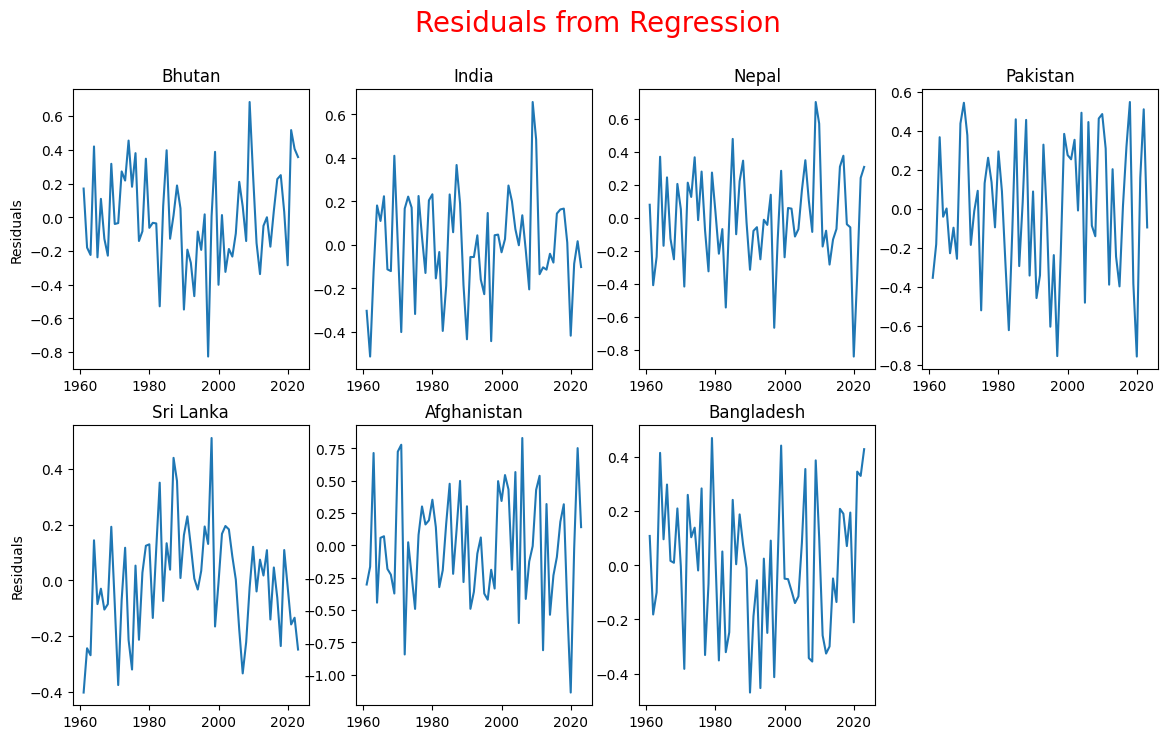

In [16]:
#FIG 4 ; STEM PLOT OF RESIDUALS (FROM PREVIOUS REGRESSION)
fig4, axs = plt.subplots(nrows=2, ncols=4, figsize=(14,8))
axs=axs.flatten()

for i,country in enumerate(sample[1:]):
    axs[i].plot(Temp_Delta.columns, Residuals.loc[country])
    axs[i].set_title(country)

axs[0].set_ylabel("Residuals")
axs[4].set_ylabel("Residuals")
axs[7].plot([],[])
axs[7].axis("off")
fig4.suptitle("Residuals from Regression",fontsize=20, color="r")
plt.show()

***

<br>

# <span style="color:red">PART C : Analysis of Inflation</span> 

- ### C.0 : Data Preparation

In [9]:
### DATA FRAME 1; HEADLINE ANNUAL PCI INFLATION (hcpi_a_i)
hcpi_a = pd.read_excel("inflation_data.xlsx", sheet_name="hcpi_a", index_col=2) # ANNUAL PCI INFLATION
sub_sample = ["India", "Nepal", "Pakistan", "Sri Lanka", "Bangladesh","Bhutan","Afghanistan"] # Countries Sub-Sample
hcpi_a = hcpi_a.loc[sub_sample] 
hcpi_a.drop(columns=["Country Code", "IMF Country Code", "Indicator Type","Series Name","Nothing","Note"], inplace=True) # Removing Columns

### DATA FRAME 2; HEADLINE QUARTER PCI (hcpi_q) and HEADLINE QUARTERLY INFLATION (hcpi_q_i)
hcpi_q = pd.read_excel("inflation_data.xlsx", sheet_name="hcpi_q", index_col=2).round(decimals=2) # QUARTERLY PCI
sub_sample = ["India" ,"Nepal", "Pakistan", "Sri Lanka"] # Countries for which i have ENOUGH data
hcpi_q = hcpi_q.loc[sub_sample] 
hcpi_q.drop(columns=["Country Code", "IMF Country Code", "Indicator Type","Series Name","Note","Data source", "Base date"], inplace=True) # Removing Columns
hcpi_q_i = hcpi_q.pct_change(axis=1,fill_method=None) # I use pct change to compute the QUARTER INFLATION from the QUARTER PCI
del hcpi_q_i[hcpi_q_i.columns[0]]

### DATA FRAME 3; HEADLINE MONTHLY CPI (hcpi_m) and HEADLINE MONTHLY INFLATION (hcpi_m_i)
hcpi_m = pd.read_excel("inflation_data.xlsx", sheet_name="hcpi_m", index_col=2) #MONTHLY CPI
sub_sample = ["India" ,"Nepal", "Pakistan", "Sri Lanka"] # Countries for which i have ENOUGH data
hcpi_m = hcpi_m.loc[sub_sample] 
hcpi_m.drop(columns=["Country Code", "IMF Country Code", "Indicator Type","Series Name","Note","Data source", "Base date"], inplace=True) # Removing Columns
hcpi_m_i = hcpi_m.pct_change(axis=1,fill_method=None) # I use pct change to compute the MONTLHY INFLATION from the MONTHLY PCI

### DATA FRAME 4; ANNUAL FOOD PRICE INDEX (fcpi_a) AND ANNUAL FOOD INFLATION (fcpi_a_i)
fcpi_a_i = pd.read_excel("inflation_data.xlsx", sheet_name="fcpi_a", index_col=2) #Food Core Price Index - Motnhly Inflation
sub_sample = ["India","Nepal", "Pakistan", "Sri Lanka","Bangladesh"] # Countries Sub-Sample for which i have ENOUGH data
fcpi_a_i = fcpi_a_i.loc[sub_sample] 
fcpi_a_i.drop(columns=["Country Code", "IMF Country Code", "Indicator Type","Series Name","Nothing","Note"], inplace=True) # Removing Columns
hcpi_m


,1970-01-01,1970-02-01,1970-03-01,1970-04-01,1970-05-01,1970-06-01,1970-07-01,1970-08-01,1970-09-01,1970-10-01,...,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
Country,,,,,,,,,,,,,,,,,,,,,
India,3.000000,3.000000,3.000000,3.000000,3.100000,3.100000,3.100000,3.100000,3.200000,3.200000,...,142.300000,143.100000,143.400000,144.700000,146.000000,146.000000,145.763000,146.31400,146.204000,NaN
Nepal,4.109493,4.282496,4.388959,4.442191,4.511393,4.585917,4.569947,4.689719,4.641810,4.628502,...,221.970143,222.895999,226.599420,227.393010,228.671572,NaN,NaN,NaN,NaN,NaN
Pakistan,2.890375,2.904219,2.902089,2.910183,2.931481,2.973438,2.991755,3.010923,2.984513,2.994097,...,259.879215,271.179584,277.821876,274.623934,287.547613,280.179904,291.156525,299.54806,312.487485,324.113351
Sri Lanka,1.973504,1.970632,1.973504,1.986431,1.990740,1.990740,1.972068,1.974941,1.992177,1.992177,...,277.833732,293.315612,300.516486,307.477331,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
hcpi_m_i

,1970-01-01,1970-02-01,1970-03-01,1970-04-01,1970-05-01,1970-06-01,1970-07-01,1970-08-01,1970-09-01,1970-10-01,...,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
Country,,,,,,,,,,,,,,,,,,,,,
India,NaN,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.032258,0.000000,...,0.001407,0.005622,0.002096,0.009066,0.008984,0.000000,-0.001623,0.003780,-0.000752,NaN
Nepal,NaN,0.042098,0.024860,0.012129,0.015578,0.016519,-0.003482,0.026209,-0.010216,-0.002867,...,0.010707,0.004171,0.016615,0.003502,0.005623,NaN,NaN,NaN,NaN,NaN
Pakistan,NaN,0.004790,-0.000733,0.002789,0.007319,0.014313,0.006160,0.006407,-0.008771,0.003211,...,0.063444,0.043483,0.024494,-0.011511,0.047060,-0.025623,0.039177,0.028821,0.043196,0.037204
Sri Lanka,NaN,-0.001456,0.001458,0.006550,0.002169,0.000000,-0.009380,0.001457,0.008727,0.000000,...,0.109248,0.055724,0.024550,0.023163,NaN,NaN,NaN,NaN,NaN,NaN


- ### C.1 : Headline CPI Annual Inflation 

- ### C.2 : Headline CPI Quarterly Inflation 

- ### C.3 : Headline CPI Monthly Inflation 

- ### C.4 : Food Annual Inflation 